# Pytorch LSTM example 

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
data_csv = pd.read_csv('data/international-airline-passengers.csv', usecols=[1])
look_back=5

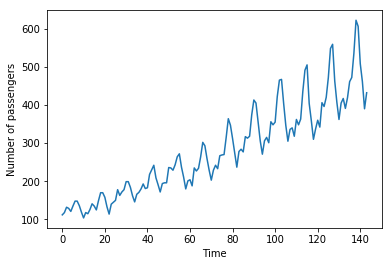

In [89]:
plt.plot(data_csv)
plt.xlabel("Time")
plt.ylabel("Number of passengers")
plt.show()

In [90]:

data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [91]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [92]:

data_X, data_Y = create_dataset(dataset, look_back)
print(look_back)

5


In [93]:

train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [94]:
import torch

train_X = train_X.reshape(-1, 1, look_back)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, look_back)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
print(train_X.size)

485


In [95]:
from torch import nn
from torch.autograd import Variable

In [96]:

class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) 
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [97]:
net = lstm_reg(look_back, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [98]:

for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)

    out = net(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: 
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00400
Epoch: 200, Loss: 0.00337
Epoch: 300, Loss: 0.00303
Epoch: 400, Loss: 0.00192
Epoch: 500, Loss: 0.00169
Epoch: 600, Loss: 0.00149
Epoch: 700, Loss: 0.00132
Epoch: 800, Loss: 0.00120
Epoch: 900, Loss: 0.00080
Epoch: 1000, Loss: 0.00067


In [99]:
net = net.eval() 

In [101]:
data_X = data_X.reshape(-1, 1, look_back)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) 

In [102]:

pred_test = pred_test.view(-1).data.numpy()

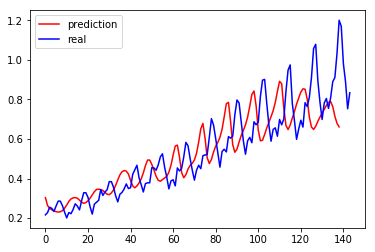

In [103]:

plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')